In [1]:
import pandas as pd
import re
import numpy as np
import plotly.graph_objects as go
import urllib, json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

## Import data

In [2]:
# Read in prior approval data from local directory

priors = 'Prior approvals for analysis 20211215'

df = pd.read_excel(priors+'.xlsx')

### Filter out refused applications

In [3]:
#### Filter out refused applications

refusals = df[df['Status (groups)']=='Refused']

df = df[(df['Status (groups)']!= 'Refused ')&(df['Status (groups)']!= 'Refused')]

## Clean Date Fields

In [4]:
### Convert time to Month-Year

# Where the value for 'Decision date' is null, replace it with 'Valid date'
df['date'] = np.where(pd.to_datetime(df['Decision date']).isnull(),pd.to_datetime(df['Valid date']),pd.to_datetime(df['Decision date']))

df['month_year'] = df['date'].apply(lambda x: x.strftime('%B-%Y') if x > pd.to_datetime("2000-12-30") else None )

df['year'] =  df['date'].apply(lambda x: x.strftime('%Y') if x > pd.to_datetime("2000-12-30") else None )

## Clean Change of Use Fields

A significant amount of rows lack a value for 'application_type_full' so 'Application type (assumed)' used instead as suggested by Greater London Authority.  

In [5]:
df['Application type on Datahub'].value_counts(dropna = False).head()

NaN                                                                  14595
Prior Approval: Change of use - offices to dwellinghouses             4358
Prior Approval: Larger Home Extension                                 2343
Prior Approval: Change of use - retail/takeaway to dwellinghouses      640
Lawful development: Proposed use                                       563
Name: Application type on Datahub, dtype: int64

In [6]:
df['Application type (assumed)'].value_counts(dropna = False).head()

Prior Approval: Larger Home Extension                                14712
Prior Approval: Change of use - offices to dwellinghouses             4694
Lawful development: Proposed use                                       902
Prior Approval: Change of use - retail/takeaway to dwellinghouses      647
Prior Approval: Development for electronic communications network      508
Name: Application type (assumed), dtype: int64

In [7]:
df['application_type_new'] = df['Application type (assumed)']

In [8]:
### Create a mapping schema to simplify names

type_map = {
    'retail/takeaway':'retail/service/takeaway/etc',
    'retail/service/etc':'retail/service/takeaway/etc',
    'Commercial, Business and Service':'commercial/business/service',
    'retail':'retail/service/takeaway/etc',
    'commercial/business/service/etc':'commercial/business/service',
    'mixed use including up':'commercial/business/service'
}

In [9]:
# Most changes can be caught using a simple formula, splitting text patterns
# Additional elif clauses added for handling fringe cases

def split_change(text):
    changed_from = None
    changed_to = None
    if isinstance(text, str):
        if ' to ' in text and ' - ' in text:
            split = re.split(r' to ', text)
            changed_to = split[1]
            changed_from = re.split(r' - ',split[0])[1]
    # Handle fringe cases that may not follow above format
        elif text == 'Retail to residential':
            changed_to = 'dwellinghouses'
            changed_from = 'retail'
        elif text == 'Prior Approval: Change of use from Commercial, Business and Service (Use Class E) to Dwellinghouses (Use Class C3)':
            changed_to = 'dwellinghouses'
            changed_from = 'Commercial, Business and Service'
    if changed_to in type_map:
        changed_to = type_map[changed_to]
    if changed_from in type_map:
        changed_from = type_map[changed_from]
    return (changed_to, changed_from)      

In [10]:
### Apply function to split change to before/after

df['changes'] = df['application_type_new'].apply(lambda x: split_change(x))

df['changed_from'] = df['changes'].apply(lambda x: x[1])

df['changed_to'] = df['changes'].apply(lambda x: x[0])

In [11]:
### Create a dataframe of non-null values
### This indicates that there has been a change in use

non_null_df = df[df['changes']!= (None, None)]

non_null_df['changes'].value_counts()

(dwellinghouses, offices)                                     4694
(dwellinghouses, retail/service/takeaway/etc)                  921
(dwellinghouses, storage)                                      189
(restaurant/café, retail/service/takeaway/etc)                 127
(dwellinghouses, commercial/business/service)                  126
(dwellinghouses, light industrial)                              34
(school/nursery, business/hotels/etc)                           28
(dwellinghouses, agriculture)                                   10
(dwellinghouses, amusements/casinos)                             8
(assembly/leisure, retail/service/takeaway/etc)                  7
(offices, retail/service/takeaway/etc)                           3
(business/hotels/etc, school/nursery)                            2
(commercial/business/service, commercial/business/service)       1
Name: changes, dtype: int64

In [12]:
# Quick function to clean up the formatting of the to/from labels
# Important bit is to add the extra space to some labels (either to or from) to make it different, otherwise Sankey chart will be distorted


def clean_labels(x):
    to = x[0]
    fr = x[1]
    to = to.capitalize()
    fr = fr.capitalize()
    to = ' '+to
    return (to, fr)

### All Changes

In [13]:
change_df = pd.DataFrame(non_null_df['changes'].value_counts()).reset_index()
change_df['index'] = change_df['index'].apply(lambda x: clean_labels(x))
change_df['changed_to'] = change_df['index'].apply(lambda x: x[0])
change_df['changed_from'] = change_df['index'].apply(lambda x: x[1])
change_df

,index,changes,changed_to,changed_from
0,"( Dwellinghouses, Offices)",4694,Dwellinghouses,Offices
1,"( Dwellinghouses, Retail/service/takeaway/etc)",921,Dwellinghouses,Retail/service/takeaway/etc
2,"( Dwellinghouses, Storage)",189,Dwellinghouses,Storage
3,"( Restaurant/café, Retail/service/takeaway/etc)",127,Restaurant/café,Retail/service/takeaway/etc
4,"( Dwellinghouses, Commercial/business/service)",126,Dwellinghouses,Commercial/business/service
5,"( Dwellinghouses, Light industrial)",34,Dwellinghouses,Light industrial
6,"( School/nursery, Business/hotels/etc)",28,School/nursery,Business/hotels/etc
7,"( Dwellinghouses, Agriculture)",10,Dwellinghouses,Agriculture
8,"( Dwellinghouses, Amusements/casinos)",8,Dwellinghouses,Amusements/casinos
9,"( Assembly/leisure, Retail/service/takeaway/etc)",7,Assembly/leisure,Retail/service/takeaway/etc


In [14]:
### Add numeric values and totals to labels

# List of unique values
changed_to = set(list(change_df['changed_to']))

# Aggreate using groupby to get a total figure
changed_to_totals = change_df.groupby('changed_to').agg({'changes':'sum'})

# Re-do the list, but add the total via a lookup
changed_to = [x+': '+str(changed_to_totals['changes'][x]) for x in changed_to]

# List of unique values
changed_from = set(list(change_df['changed_from']))

# Aggreate using groupby to get a total figure
changed_from_totals = change_df.groupby('changed_from').agg({'changes':'sum'})

# Re-do the list, but add the total via a lookup
changed_from = [x+': '+str(changed_from_totals['changes'][x]) for x in changed_from]

types_count = changed_to+changed_from

types_count = sorted(types_count)

In [60]:
types = sorted(list(set(list(change_df['changed_to'])+list(change_df['changed_from']))))

value_dict = dict(zip(change_df['index'], change_df['changes']))

fig = go.Figure(data=[go.Sankey(
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
        label = types_count
    ),
    # Add links
    link = dict(
      source =  [types.index(x) for x in change_df['changed_from']],
      target =  [types.index(x) for x in change_df['changed_to']],
      value =  [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])],
    label = [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])]))])
    #  color =  data['data'][0]['link']['color']
#))])

# fig.update_layout(title_text="Prior Approvals - Change of Use",font_size=10)
# fig.show()

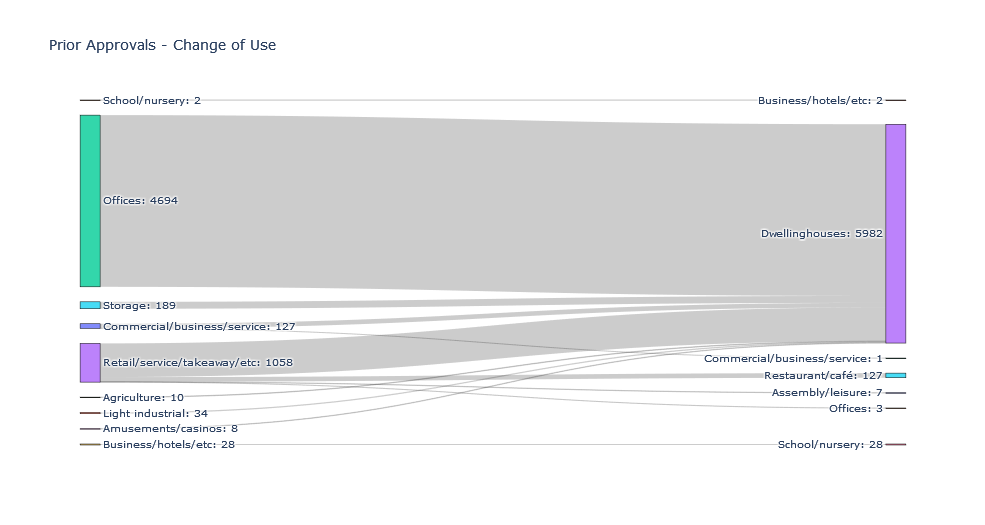

### Changes in 2021

In [16]:

change_df = pd.DataFrame(non_null_df[non_null_df['date']>=pd.to_datetime('2021')]['changes'].value_counts()).reset_index()
change_df['index'] = change_df['index'].apply(lambda x: clean_labels(x))
change_df['changed_to'] = change_df['index'].apply(lambda x: x[0])
change_df['changed_from'] = change_df['index'].apply(lambda x: x[1])
change_df

,index,changes,changed_to,changed_from
0,"( Dwellinghouses, Offices)",232,Dwellinghouses,Offices
1,"( Dwellinghouses, Retail/service/takeaway/etc)",132,Dwellinghouses,Retail/service/takeaway/etc
2,"( Dwellinghouses, Commercial/business/service)",102,Dwellinghouses,Commercial/business/service
3,"( Restaurant/café, Retail/service/takeaway/etc)",25,Restaurant/café,Retail/service/takeaway/etc
4,"( School/nursery, Business/hotels/etc)",4,School/nursery,Business/hotels/etc
5,"( Dwellinghouses, Light industrial)",3,Dwellinghouses,Light industrial
6,"( Dwellinghouses, Agriculture)",2,Dwellinghouses,Agriculture
7,"( Dwellinghouses, Amusements/casinos)",2,Dwellinghouses,Amusements/casinos
8,"( Offices, Retail/service/takeaway/etc)",1,Offices,Retail/service/takeaway/etc
9,"( Commercial/business/service, Commercial/busi...",1,Commercial/business/service,Commercial/business/service


In [17]:
### Add numeric values and totals to labels

# List of unique values
changed_to = set(list(change_df['changed_to']))

# Aggreate using groupby to get a total figure
changed_to_totals = change_df.groupby('changed_to').agg({'changes':'sum'})

# Re-do the list, but add the total via a lookup
changed_to = [x+': '+str(changed_to_totals['changes'][x]) for x in changed_to]

# List of unique values
changed_from = set(list(change_df['changed_from']))

# Aggreate using groupby to get a total figure
changed_from_totals = change_df.groupby('changed_from').agg({'changes':'sum'})

# Re-do the list, but add the total via a lookup
changed_from = [x+': '+str(changed_from_totals['changes'][x]) for x in changed_from]

types_count = changed_to+changed_from

types_count = sorted(types_count)

In [59]:
types = sorted(list(set(list(change_df['changed_to'])+list(change_df['changed_from']))))

value_dict = dict(zip(change_df['index'], change_df['changes']))

fig = go.Figure(data=[go.Sankey(
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 50,
      line = dict(color = "black", width = 0.5),
        label = types_count
    ),
    # Add links
    link = dict(
      source =  [types.index(x) for x in change_df['changed_from']],
      target =  [types.index(x) for x in change_df['changed_to']],
      value =  [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])],
    label = [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])]))])
    #  color =  data['data'][0]['link']['color']
#))])

#fig.update_layout(title_text="Prior Approvals - Change of Use - 2021",font_size=10)
#fig.show()

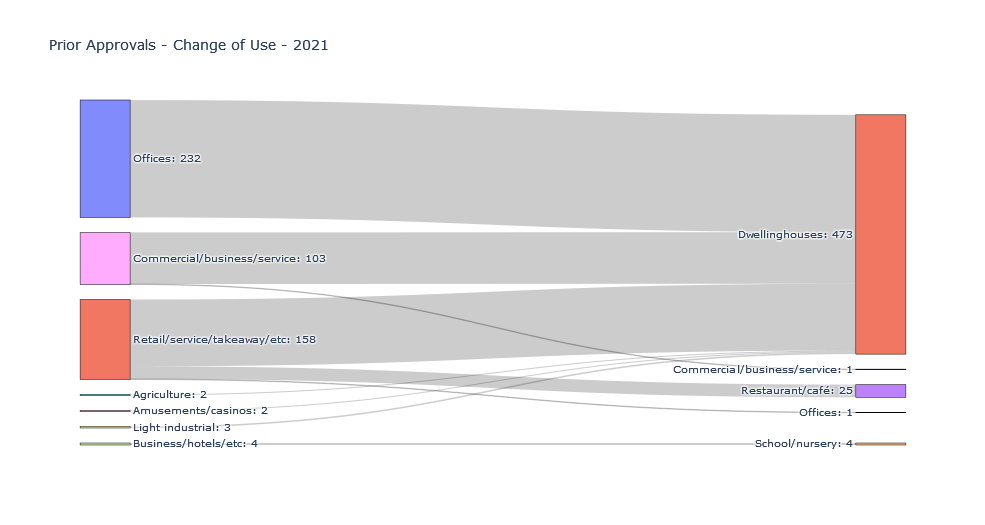

## Residential Conversions

In [19]:
### Flag Residential Conversions

# May need to change this logic later if conversion name changes

df['residential_conversion'] = df['changed_to'].apply(lambda x: True if x == "dwellinghouses" else False)

In [20]:
df['changed_to'].value_counts(dropna = False)

NaN                            16839
dwellinghouses                  5982
restaurant/café                  127
school/nursery                    28
assembly/leisure                   7
offices                            3
business/hotels/etc                2
commercial/business/service        1
Name: changed_to, dtype: int64

In [21]:
### Flag whether on a High Street or in a City Centre

def isNaN(x):
    return x != x

df['High Street'] = df['High Street name'].apply(lambda x: 0 if isNaN(x) else 1)

df['Town Centre'] = df['Town Centre Name'].apply(lambda x: 0 if isNaN(x) else 1)

In [22]:
df[['High Street name','High Street']].head()

,High Street name,High Street
0,"Broad Street, Dagenham.",1
1,"High Road, Seven Kings.",1
2,NaN,0
3,"North Street, Barking.",1
4,"High Road, Seven Kings.",1


In [23]:
### Monthly residential conversions

residential_converstions_monthly = df[df['residential_conversion']==True].groupby('month_year').agg({'id':'count','Residential units proposed':'sum','Existing non-residential floorspace':'median','High Street':'sum','Town Centre':'sum'})

residential_converstions_monthly = pd.DataFrame(residential_converstions_monthly).reset_index()
residential_converstions_monthly['month_year'] = pd.to_datetime(residential_converstions_monthly['month_year'], format = "%B-%Y")
residential_converstions_monthly = residential_converstions_monthly.sort_values('month_year')


# Monthly proportion of high street and town centre prior approvals

residential_converstions_monthly['Pct High Street'] = residential_converstions_monthly['High Street']/residential_converstions_monthly['id']
residential_converstions_monthly['Pct Town Centre'] = residential_converstions_monthly['Town Centre']/residential_converstions_monthly['id']
residential_converstions_monthly =residential_converstions_monthly.dropna()
#residential_converstions_monthly['month_year'] = residential_converstions_monthly['month_year'].apply(lambda x: x.strftime('%B-%Y') if x > pd.to_datetime("2000-12-30") else None)

In [24]:
### Annual residential conversions

residential_converstions_annual = df[df['residential_conversion']==True].groupby('year').agg({'id':'count','Residential units proposed':'sum','Existing non-residential floorspace':'median','High Street':'sum','Town Centre':'sum'})
residential_converstions_annual = pd.DataFrame(residential_converstions_annual).reset_index()
residential_converstions_annual['year'] = pd.to_datetime(residential_converstions_annual['year'], format = "%Y")
residential_converstions_annual = residential_converstions_annual.sort_values('year')

residential_converstions_annual['Pct High Street'] = residential_converstions_annual['High Street']/residential_converstions_annual['id']
residential_converstions_annual['Pct Town Centre'] = residential_converstions_annual['Town Centre']/residential_converstions_annual['id']

residential_converstions_annual =residential_converstions_annual.dropna()

#### Total prior approval residential conversions by month

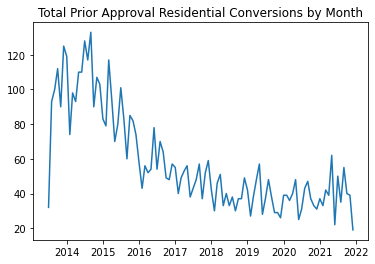

In [25]:
# Doesn't appear that there have been a huge spike in residential converstions after August--but would be expecting a jump
# in August? Or just 2021?

# 

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['id'])
plt.title('Total Prior Approval Residential Conversions by Month')
plt.show()

#### Total prior approval residential conversions by year

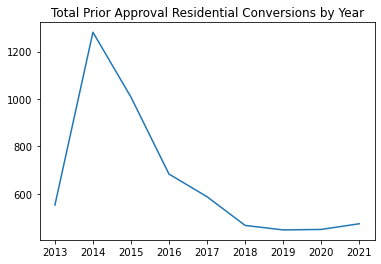

In [26]:
# Doesn't appear that there have been a huge spike in residential converstions after August--but would be expecting a jump
# in August? Or just 2021?

# 

plt.plot(residential_converstions_annual['year'],residential_converstions_annual['id'])
plt.title('Total Prior Approval Residential Conversions by Year')
plt.show()

#### Median non-residential floorspace by month

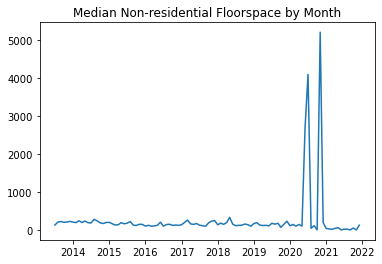

In [27]:
# A few months look like outliers--group annually to smooth? -- June, July, Nov 2020
# This is due to null values in the floorspace field and only a few large values

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Existing non-residential floorspace'])
plt.title('Median Non-residential Floorspace by Month')
plt.show()

#### Median non-residential floor space by year

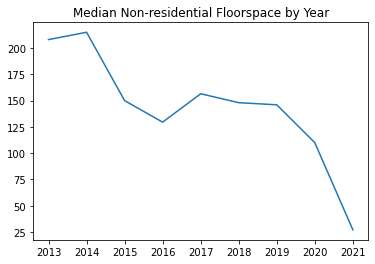

In [28]:
# A few months look like outliers--group annually to smooth? -- June, July, Nov 2020

# Would it be possible assume that the average floorspace per unit is simply this column divided by the 

plt.plot(residential_converstions_annual['year'],residential_converstions_annual['Existing non-residential floorspace'])
plt.title('Median Non-residential Floorspace by Year')
plt.show()

#### Sum of 'Residential units proposed' by month

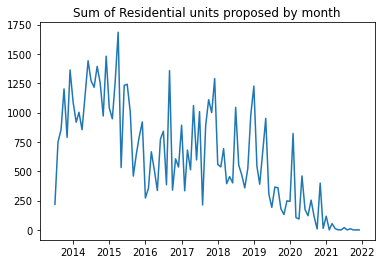

In [29]:
# Why 0 units in most recent months?

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Residential units proposed'])
plt.title('Sum of Residential units proposed by month')
plt.show()

In [30]:
residential_converstions_monthly.tail(20)

,month_year,id,Residential units proposed,Existing non-residential floorspace,High Street,Town Centre,Pct High Street,Pct Town Centre
73,2020-05-01,48,460.0,100.00,24,13,0.500000,0.270833
57,2020-06-01,25,173.0,2683.00,16,7,0.640000,0.280000
49,2020-07-01,31,121.0,4092.50,17,6,0.548387,0.193548
15,2020-08-01,43,254.0,41.00,23,12,0.534884,0.279070
100,2020-09-01,47,113.0,113.00,22,5,0.468085,0.106383
91,2020-10-01,37,8.0,0.00,19,6,0.513514,0.162162
82,2020-11-01,33,399.0,5203.50,18,8,0.545455,0.242424
24,2020-12-01,31,13.0,193.00,20,8,0.645161,0.258065
41,2021-01-01,37,117.0,38.00,22,6,0.594595,0.162162
33,2021-02-01,33,0.0,25.95,24,14,0.727273,0.424242


#### Sum of 'Residential units proposed' by year

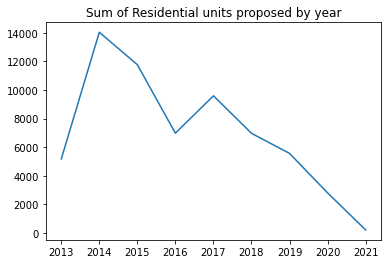

In [31]:
# Have I set myself up so that I'm using incomplete data? 
plt.plot(residential_converstions_annual['year'],residential_converstions_annual['Residential units proposed'])
plt.title('Sum of Residential units proposed by year')
plt.show()

In [32]:
residential_converstions_monthly

,month_year,id,Residential units proposed,Existing non-residential floorspace,High Street,Town Centre,Pct High Street,Pct Town Centre
42,2013-07-01,32,218.0,129.0,18,7,0.562500,0.218750
8,2013-08-01,93,748.0,208.0,64,34,0.688172,0.365591
93,2013-09-01,100,855.0,220.0,70,38,0.700000,0.380000
84,2013-10-01,112,1202.0,199.0,77,45,0.687500,0.401786
75,2013-11-01,90,789.0,207.0,63,24,0.700000,0.266667
...,...,...,...,...,...,...,...,...
16,2021-08-01,35,0.0,20.0,21,8,0.600000,0.228571
101,2021-09-01,55,10.0,0.0,36,21,0.654545,0.381818
92,2021-10-01,40,0.0,50.0,17,11,0.425000,0.275000
83,2021-11-01,39,0.0,0.0,27,13,0.692308,0.333333


#### Proportion of Prior Approvals on High Streets or Town Centres

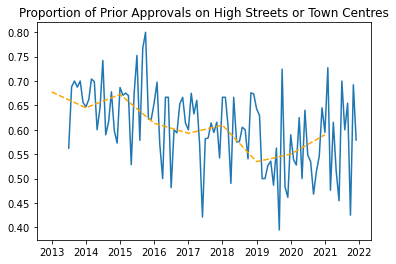

In [33]:

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Pct High Street'])
plt.plot(residential_converstions_annual['year'],residential_converstions_annual['Pct High Street'], color ='orange', linestyle = 'dashed')
plt.title('Proportion of Prior Approvals on High Streets or Town Centres')
#plt.legend(['Percent on Town Centres - Monthly','Percent on High Streets - Monthly','Percent on Town Centres - Annual','Percent on High Streets - Annual'])
plt.show()

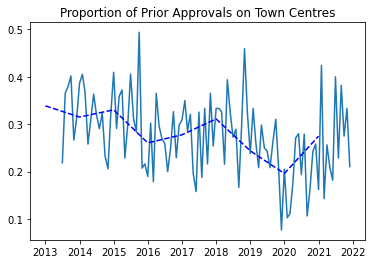

In [34]:
plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Pct Town Centre'])
plt.plot(residential_converstions_annual['year'],residential_converstions_annual['Pct Town Centre'], color ='b', linestyle = 'dashed')
plt.title('Proportion of Prior Approvals on Town Centres')
plt.show()

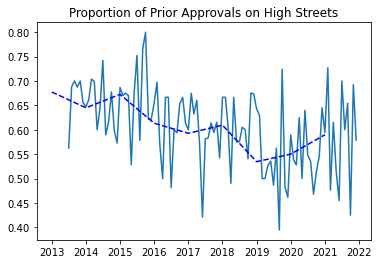

In [35]:
plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Pct High Street'])
plt.plot(residential_converstions_annual['year'],residential_converstions_annual['Pct High Street'], color ='b', linestyle = 'dashed')
plt.title('Proportion of Prior Approvals on High Streets')
plt.show()

### Map Changes over time

In [36]:
### Hold off on mapping for now

In [37]:
gdf = gpd.read_file(folder+'Local_Planning_Authorities_(April_2019)_UK_BUC.geojson')

In [38]:
### Correct a minor data issue where different uses of 'and' or '&' create different LPAs

df['Planning authority'] = df['Planning authority'].apply(lambda x: 'Hammersmith & Fulham' if x == 'Hammersmith and Fulham' else x)

In [39]:
london_lpas = ['Camden LPA', 'City of London LPA',
       'Hackney LPA', 'Hammersmith and Fulham LPA', 'Haringey LPA',
       'Islington LPA', 'Kensington and Chelsea LPA', 'Lambeth LPA',
       'Lewisham LPA', 'Newham LPA', 'Southwark LPA', 'Tower Hamlets LPA',
       'Wandsworth LPA', 'Westminster LPA', 'Barking and Dagenham LPA',
       'Barnet LPA', 'Bexley LPA', 'Brent LPA', 'Bromley LPA',
       'Croydon LPA', 'Ealing LPA', 'Enfield LPA', 'Greenwich LPA',
       'Harrow LPA', 'Havering LPA', 'Hillingdon LPA', 'Hounslow LPA',
       'Kingston upon Thames LPA', 'Merton LPA', 'Redbridge LPA',
       'Richmond upon Thames LPA','Sutton LPA','Waltham Forest LPA',
       'Old Oak and Park Royal Development Corporation LPA','London Legacy Development Corporation LPA']

london_lpas.sort()

In [40]:
lpa_mapping = dict(zip(list(df['Planning authority'].unique()),london_lpas))
lpa_mapping

{'Barking & Dagenham': 'Barking and Dagenham LPA',
 'Barnet': 'Barnet LPA',
 'Bexley': 'Bexley LPA',
 'Brent': 'Brent LPA',
 'Bromley': 'Bromley LPA',
 'Camden': 'Camden LPA',
 'City of London': 'City of London LPA',
 'Croydon': 'Croydon LPA',
 'Ealing': 'Ealing LPA',
 'Enfield': 'Enfield LPA',
 'Greenwich': 'Greenwich LPA',
 'Hackney': 'Hackney LPA',
 'Hammersmith & Fulham': 'Hammersmith and Fulham LPA',
 'Haringey': 'Haringey LPA',
 'Harrow': 'Harrow LPA',
 'Havering': 'Havering LPA',
 'Hillingdon': 'Hillingdon LPA',
 'Hounslow': 'Hounslow LPA',
 'Islington': 'Islington LPA',
 'Kensington & Chelsea': 'Kensington and Chelsea LPA',
 'Kingston': 'Kingston upon Thames LPA',
 'Lambeth': 'Lambeth LPA',
 'Lewisham': 'Lewisham LPA',
 'LLDC': 'London Legacy Development Corporation LPA',
 'Merton': 'Merton LPA',
 'Newham': 'Newham LPA',
 'OPDC': 'Old Oak and Park Royal Development Corporation LPA',
 'Redbridge': 'Redbridge LPA',
 'Richmond': 'Richmond upon Thames LPA',
 'Southwark': 'Southwark

In [41]:
### Using the name mapping created above, create an idential name field in the dataframe

df['lpa19nm'] = df['Planning authority'].apply(lambda x: lpa_mapping[x])

In [42]:
### Merge the prior approvals dataframe to the 
gdf.head()

,objectid,lpa19cd,lpa19nm,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
0,1,E60000001,County Durham LPA,410381,532242,-1.84050,54.685131,2.232342e+09,263945.945384,"POLYGON ((-1.55941 54.88204, -1.57991 54.87777..."
1,2,E60000002,Darlington LPA,428029,515648,-1.56835,54.535339,1.988128e+08,91926.839545,"POLYGON ((-1.43836 54.59508, -1.45171 54.59083..."
2,3,E60000003,Hartlepool LPA,447157,531476,-1.27023,54.676159,9.602794e+07,51062.316765,"POLYGON ((-1.24223 54.72296, -1.25186 54.71962..."
3,4,E60000004,Middlesbrough LPA,451141,516887,-1.21099,54.544670,5.523139e+07,35500.386745,"POLYGON ((-1.19860 54.58287, -1.25236 54.59131..."
4,5,E60000005,Northumberland LPA,397861,571351,-2.03501,55.036671,3.975207e+09,608805.111435,"MULTIPOLYGON (((-2.00158 55.77855, -2.03453 55..."


In [43]:
### Create a geodataframe with all prior approvals as points

In [44]:
df.columns

Index(['id', 'Application type on Datahub', 'Application type (assumed)',
       'Development description', 'Status (groups)', 'Status', 'Decision',
       'Easting', 'Northing', 'postcode', 'Planning authority',
       'Application number', 'Valid date', 'Decision date',
       'Residential units proposed', 'Existing use class (from Datahub)',
       'Existing non-residential floorspace', 'High Street name',
       'Town Centre Name', 'Planned Article 4 Direction', 'Adopted OA name',
       'date', 'month_year', 'year', 'application_type_new', 'changes',
       'changed_from', 'changed_to', 'residential_conversion', 'High Street',
       'Town Centre', 'lpa19nm'],
      dtype='object')

In [45]:
df[['Easting','Northing']].describe()

,Easting,Northing
count,22375.000000,22375.000000
mean,525737.205765,179807.246883
std,24144.176204,10998.327928
min,0.000000,0.000000
25%,516371.000000,173188.000000
50%,524944.000000,180918.000000
75%,534790.500000,185921.500000
max,558074.000000,199975.000000


In [46]:
## Edit Easting and Northing Values

geometry = [Point(xy) for xy in zip(df.Easting.values, df.Northing.values)]

prior_approval_points = gpd.GeoDataFrame(df, geometry = geometry)

prior_approval_points = prior_approval_points[(prior_approval_points['Easting']>0)&(prior_approval_points['Northing']>0)]

In [47]:
prior_approval_points[['Easting','Northing']].describe()

,Easting,Northing
count,22339.000000,22339.000000
mean,526584.447782,180063.241595
std,11735.257682,8646.494360
min,504095.000000,156823.000000
25%,516399.500000,173206.000000
50%,524990.000000,180931.000000
75%,534798.000000,185937.500000
max,558074.000000,199975.000000


In [48]:
prior_approval_points.head()

,id,Application type on Datahub,Application type (assumed),Development description,Status (groups),Status,Decision,Easting,Northing,postcode,...,year,application_type_new,changes,changed_from,changed_to,residential_conversion,High Street,Town Centre,lpa19nm,geometry
0,Barking_&_Dagenham-13_00560_CLU_P,Prior Approval: Change of use - retail/takeawa...,Prior Approval: Change of use - retail/takeawa...,Application for a certificate of lawfulness fo...,Allowed,Superseded,NaN,549303.0,183999.0,RM10 9JA,...,2013,Prior Approval: Change of use - retail/takeawa...,"(dwellinghouses, retail/service/takeaway/etc)",retail/service/takeaway/etc,dwellinghouses,True,1,0,Barking and Dagenham LPA,POINT (549303.000 183999.000)
1,Barking_&_Dagenham-13_01133_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of proposed cha...,Allowed,Lapsed,NaN,547748.0,187941.0,RM6 6PY,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (547748.000 187941.000)
2,Barking_&_Dagenham-13_01151_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of change of us...,Allowed,Lapsed,NaN,543692.0,184058.0,IG11 8BB,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,0,0,Barking and Dagenham LPA,POINT (543692.000 184058.000)
3,Barking_&_Dagenham-13_01152_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Prior notification of change of use from B1 of...,Allowed,Lapsed,NaN,544488.0,184419.0,IG11 8TN,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (544488.000 184419.000)
4,Barking_&_Dagenham-14_00379_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Prior notification of change of use from B1 of...,Allowed,Lapsed,NaN,547938.0,187935.0,RM6 4BP,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (547938.000 187935.000)


<AxesSubplot:>

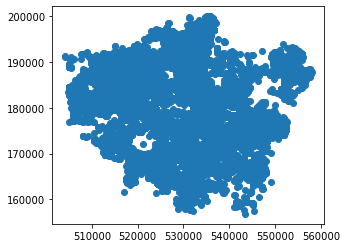

In [49]:
prior_approval_points.plot()

In [50]:
prior_approval_points_2021 = prior_approval_points[prior_approval_points['year']=='2021']
residential_points_2021 = prior_approval_points_2021[prior_approval_points_2021['residential_conversion']==True]

len(residential_points_2021)

425

In [51]:
prior_approval_points_2021.residential_conversion.value_counts(dropna = False)

False    5542
True      425
Name: residential_conversion, dtype: int64

In [52]:
len(prior_approval_points_2021)

5967

<AxesSubplot:>

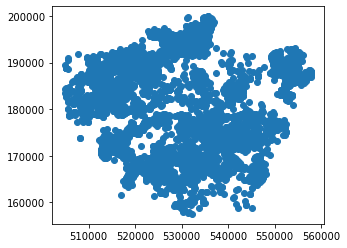

In [53]:
prior_approval_points_2021.plot()

In [54]:
prior_approval_points.head()

,id,Application type on Datahub,Application type (assumed),Development description,Status (groups),Status,Decision,Easting,Northing,postcode,...,year,application_type_new,changes,changed_from,changed_to,residential_conversion,High Street,Town Centre,lpa19nm,geometry
0,Barking_&_Dagenham-13_00560_CLU_P,Prior Approval: Change of use - retail/takeawa...,Prior Approval: Change of use - retail/takeawa...,Application for a certificate of lawfulness fo...,Allowed,Superseded,NaN,549303.0,183999.0,RM10 9JA,...,2013,Prior Approval: Change of use - retail/takeawa...,"(dwellinghouses, retail/service/takeaway/etc)",retail/service/takeaway/etc,dwellinghouses,True,1,0,Barking and Dagenham LPA,POINT (549303.000 183999.000)
1,Barking_&_Dagenham-13_01133_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of proposed cha...,Allowed,Lapsed,NaN,547748.0,187941.0,RM6 6PY,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (547748.000 187941.000)
2,Barking_&_Dagenham-13_01151_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of change of us...,Allowed,Lapsed,NaN,543692.0,184058.0,IG11 8BB,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,0,0,Barking and Dagenham LPA,POINT (543692.000 184058.000)
3,Barking_&_Dagenham-13_01152_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Prior notification of change of use from B1 of...,Allowed,Lapsed,NaN,544488.0,184419.0,IG11 8TN,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (544488.000 184419.000)
4,Barking_&_Dagenham-14_00379_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Prior notification of change of use from B1 of...,Allowed,Lapsed,NaN,547938.0,187935.0,RM6 4BP,...,2014,Prior Approval: Change of use - offices to dwe...,"(dwellinghouses, offices)",offices,dwellinghouses,True,1,1,Barking and Dagenham LPA,POINT (547938.000 187935.000)


In [55]:
pa_2021 = prior_approval_points[prior_approval_points['year']=='2021']

<AxesSubplot:>

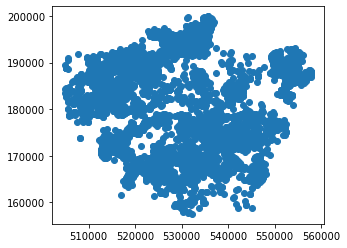

In [56]:
pa_2021.plot()